Loading dataset into DataFrame...

🔹 Next-day total prediction results:
RandomForest MAE: 4.365754759463709
RandomForest RMSE: 6.0018119110332195
XGBoost MAE: 4.899808158115258
XGBoost RMSE: 6.550676589294504


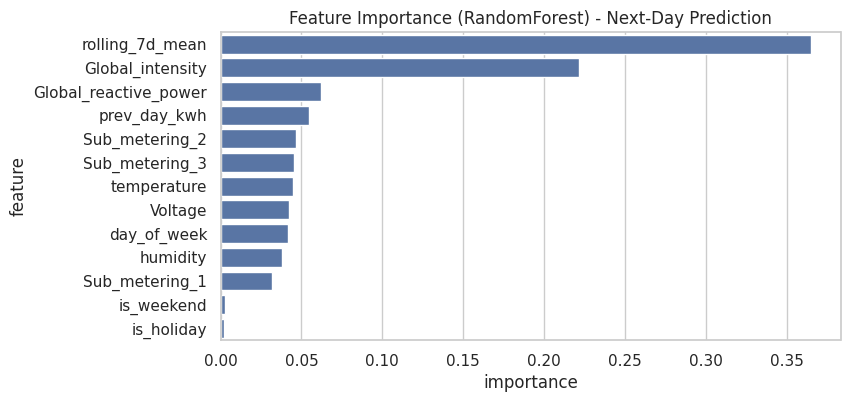

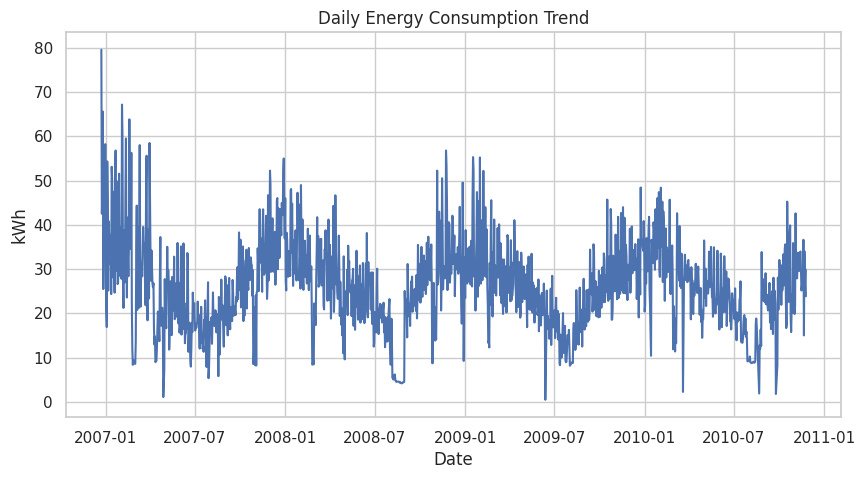


Predicted next-day total (RF) for next date after 2010-11-25 → 27.61 kWh
Slightly above average — monitor evening usage, postpone washing cycles if possible.

⚡ Estimated Energy Cost Analysis for Tomorrow ⚡
Predicted Total Energy: 27.61 kWh
Estimated Total Cost: ₹82.84
💡 Suggested Optimal Appliance Usage Hour: 2:00 hrs (cheapest period)
Minimum Hourly Cost: ₹1.38


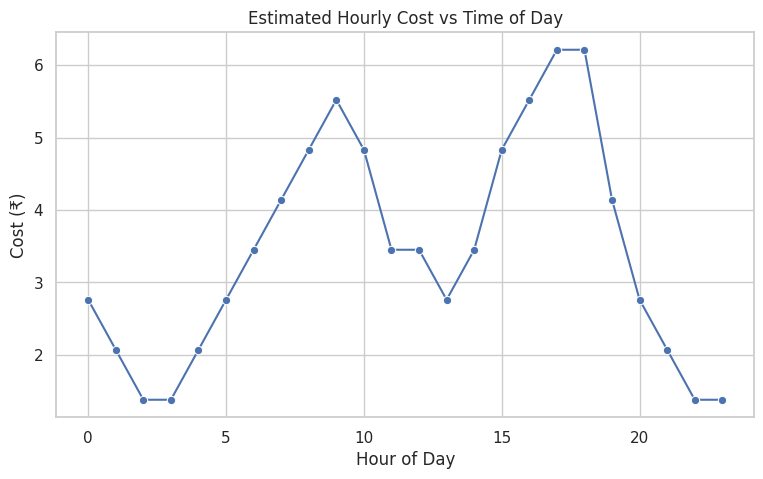

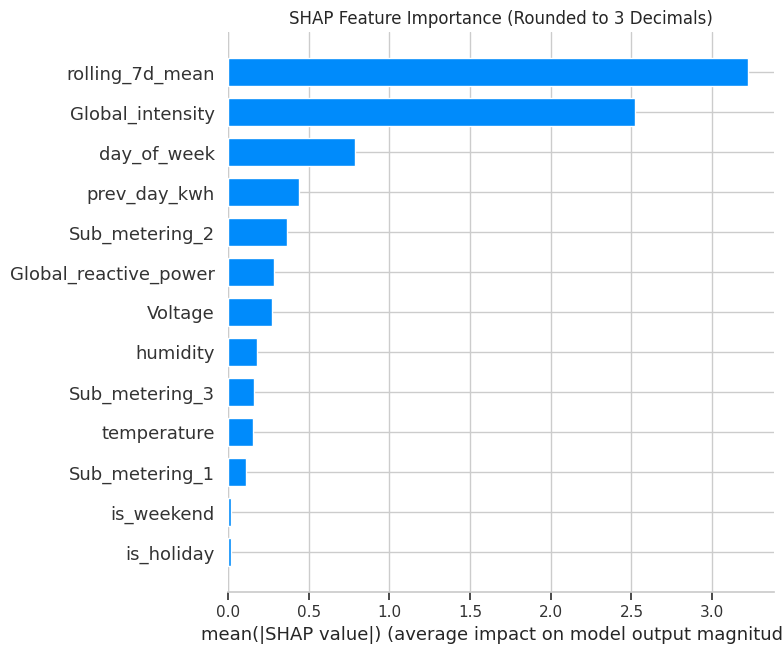

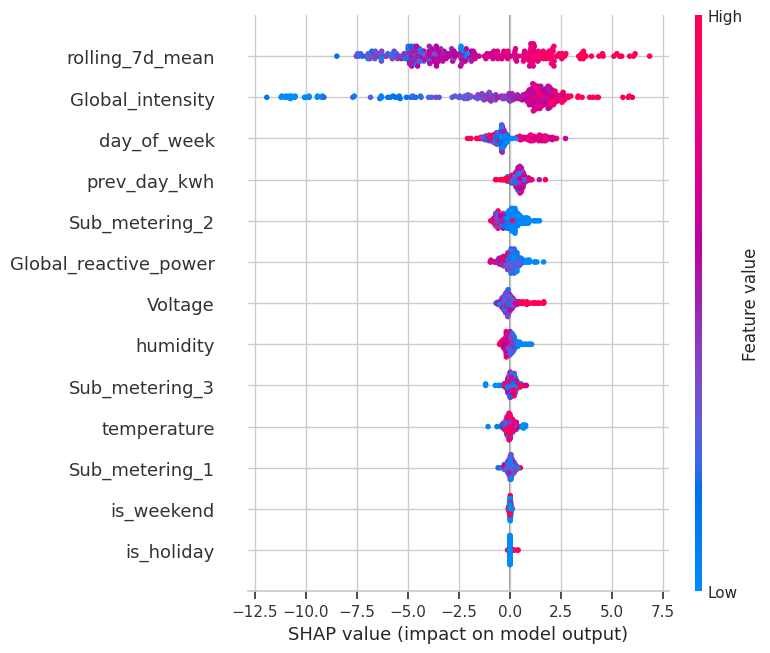

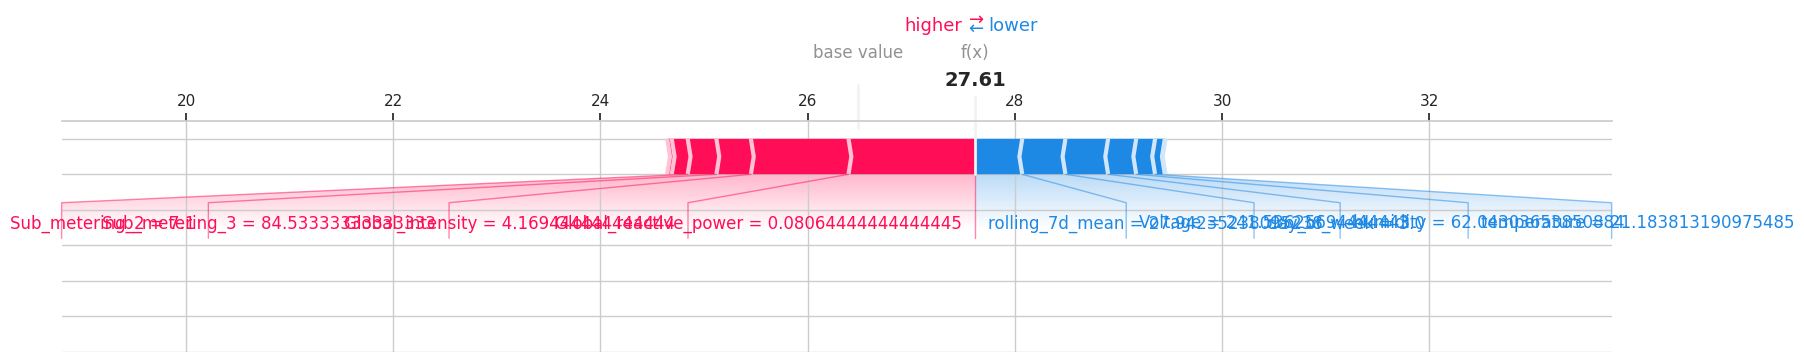


✅ SHAP feature importance exported to 'shap_feature_importance.csv'


,Feature,Mean_SHAP_Importance
1,rolling_7d_mean,3.222649
4,Global_intensity,2.523811
8,day_of_week,0.785074
0,prev_day_kwh,0.436944
6,Sub_metering_2,0.363333
2,Global_reactive_power,0.281740
3,Voltage,0.273796
10,humidity,0.177849
7,Sub_metering_3,0.162923
9,temperature,0.152933



🌍 Sustainability Impact Report:
Predicted next-day energy: 27.61 kWh
Predicted CO₂ emissions: 22.64 kg CO₂
If 10% reduction achieved → Save 2.26 kg CO₂


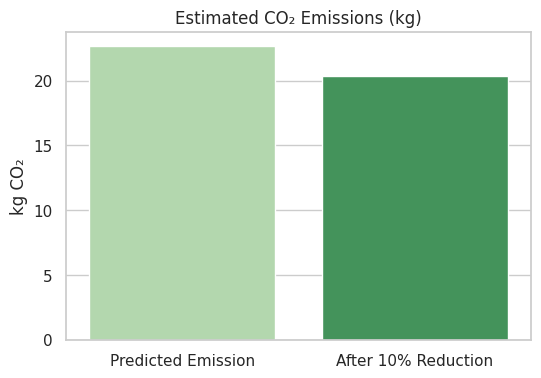


✅ Notebook finished: Next-Day Energy Consumption Predictor ready.


In [ ]:
# ================================================================
# 🌍 AI-Based Energy Consumption Predictor (Next-Day Forecast Only)
# Dataset: UCI Individual household electric power consumption
# Goal: Predict total daily energy consumption for the next day
# ================================================================

!pip install -q xgboost joblib holidays requests

import os, zipfile, io, warnings, requests, holidays
from urllib.request import urlopen
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# === Step 1: Download & Load Dataset ===
zip_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
print('Downloading dataset...')
resp = urlopen(zip_url).read()
with open('household_power_consumption.zip','wb') as f:
    f.write(resp)

with zipfile.ZipFile('household_power_consumption.zip','r') as z:
    z.extractall()

print('Loading dataset into DataFrame...')
raw = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values=['?'],
    low_memory=False
)

# === Step 2: Clean and preprocess (updated for new pandas) ===
raw['datetime'] = pd.to_datetime(raw['Date'] + ' ' + raw['Time'],
                                 dayfirst=True, errors='coerce')

cols = ['Global_active_power','Global_reactive_power','Voltage',
        'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']
for c in cols:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

raw = raw.dropna(subset=['datetime'])
raw = raw.sort_values('datetime').reset_index(drop=True)
raw = raw.set_index('datetime')

# Hourly & Daily Aggregation
hourly = raw[cols].resample('h').mean().dropna().reset_index()
hourly['date'] = hourly['datetime'].dt.date

daily = hourly.groupby('date').agg({
    'Global_active_power':'sum',  # total daily usage in kWh
    'Global_reactive_power':'mean',
    'Voltage':'mean',
    'Global_intensity':'mean',
    'Sub_metering_1':'sum',
    'Sub_metering_2':'sum',
    'Sub_metering_3':'sum'
}).rename(columns={'Global_active_power':'daily_kwh'}).reset_index()

# Add lag and rolling features
daily['prev_day_kwh'] = daily['daily_kwh'].shift(1)
daily['rolling_7d_mean'] = daily['daily_kwh'].rolling(7).mean().shift(1)

# === Step: Add external context (Weather + Holiday) ===
np.random.seed(42)

# --- Weather simulation (replace with live API if desired) ---
# Example for real API:
# API_KEY = "YOUR_API_KEY"
# CITY = "Delhi"
# def fetch_weather():
#     url = f"https://api.openweathermap.org/data/2.5/weather?q={CITY}&appid={API_KEY}&units=metric"
#     data = requests.get(url).json()
#     return data['main']['temp'], data['main']['humidity']

daily['temperature'] = 25 + np.sin(np.arange(len(daily))/30)*10 + np.random.normal(0,2,len(daily))
daily['humidity'] = 60 + np.random.normal(0,5,len(daily))

# --- Holiday & Weekend flags ---
india_holidays = holidays.India(years=range(2006,2011))
daily['is_holiday'] = daily['date'].apply(lambda d: 1 if d in india_holidays else 0)
daily['is_weekend'] = pd.to_datetime(daily['date']).dt.dayofweek.isin([5,6]).astype(int)

# Day of week & target
daily['day_of_week'] = pd.to_datetime(daily['date']).dt.dayofweek
daily['target_next_day_kwh'] = daily['daily_kwh'].shift(-1)
daily = daily.dropna().reset_index(drop=True)

# === Step 3: Model Training ===
features = [
    'prev_day_kwh','rolling_7d_mean','Global_reactive_power','Voltage',
    'Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3',
    'day_of_week','temperature','humidity','is_holiday','is_weekend'
]
X = daily[features]
y = daily['target_next_day_kwh']

# Time-based split
split_idx = int(len(X)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

xgb = XGBRegressor(n_estimators=300, random_state=42, verbosity=0)
xgb.fit(X_train_scaled, y_train)

# === Step 4: Evaluate ===
pred_rf = rf.predict(X_test)
pred_xgb = xgb.predict(X_test_scaled)

print('\n🔹 Next-day total prediction results:')
print('RandomForest MAE:', mean_absolute_error(y_test, pred_rf))
print('RandomForest RMSE:', np.sqrt(mean_squared_error(y_test, pred_rf)))
print('XGBoost MAE:', mean_absolute_error(y_test, pred_xgb))
print('XGBoost RMSE:', np.sqrt(mean_squared_error(y_test, pred_xgb)))

# === Step 5: Feature Importance & Visualizations ===
imp = rf.feature_importances_
imp_df = pd.DataFrame({'feature': features, 'importance': imp}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=imp_df)
plt.title('Feature Importance (RandomForest) - Next-Day Prediction')
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x='date', y='daily_kwh', data=daily)
plt.title('Daily Energy Consumption Trend')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.show()

# === Step 6: Make Next-Day Prediction ===
recent = X.iloc[-1:]
pred_nextday_rf = rf.predict(recent)[0]
print(f'\nPredicted next-day total (RF) for next date after {daily.date.iloc[-1]} → {pred_nextday_rf:.2f} kWh')

# === Step 7: Recommendation ===
def recommend_next_day(pred_kwh):
    avg_daily = daily['daily_kwh'].mean()
    if pred_kwh > avg_daily * 1.2:
        return 'High consumption forecast for tomorrow — reduce AC runtime, avoid multiple heavy appliances.'
    elif pred_kwh > avg_daily * 1.05:
        return 'Slightly above average — monitor evening usage, postpone washing cycles if possible.'
    else:
        return 'Tomorrow looks normal.'

print(recommend_next_day(pred_nextday_rf))

# === Step 8: Cost Optimization & Scheduling ===
# Define a simple tariff structure (₹ per kWh)
# These values can be changed based on your region's tariff data
tariff = {
    "off_peak": 3.0,   # 11 PM – 6 AM
    "mid_peak": 5.0,   # 6 AM – 6 PM
    "peak": 7.0        # 6 PM – 11 PM
}

# Create a sample hourly pattern for tomorrow
hours = np.arange(0, 24)

# Split total predicted energy roughly across hours (normalized pattern)
# This simulates how energy might be distributed throughout the day
pattern = np.array([0.04,0.03,0.02,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.07,0.05,
                    0.05,0.04,0.05,0.07,0.08,0.09,0.09,0.06,0.04,0.03,0.02,0.02])
pattern = pattern / pattern.sum()  # Normalize to sum to 1
predicted_usage = pred_nextday_rf * pattern  # distribute total energy by hour

# Estimate cost for each hour
costs = []
for hour, kwh in zip(hours, predicted_usage):
    if 23 >= hour or hour < 6:
        rate = tariff['off_peak']
    elif 6 <= hour < 18:
        rate = tariff['mid_peak']
    else:
        rate = tariff['peak']
    costs.append(kwh * rate)

total_cost = np.sum(costs)
opt_hour = hours[np.argmin(costs)]

print("\n⚡ Estimated Energy Cost Analysis for Tomorrow ⚡")
print(f"Predicted Total Energy: {pred_nextday_rf:.2f} kWh")
print(f"Estimated Total Cost: ₹{total_cost:.2f}")
print(f"💡 Suggested Optimal Appliance Usage Hour: {opt_hour}:00 hrs (cheapest period)")
print(f"Minimum Hourly Cost: ₹{min(costs):.2f}")

# Optional: visualize cost variation throughout the day
plt.figure(figsize=(9,5))
sns.lineplot(x=hours, y=costs, marker='o')
plt.title('Estimated Hourly Cost vs Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Cost (₹)')
plt.show()

# === Step 9: Explainability using SHAP (3-decimal precision) ===
!pip install -q shap

import shap
shap.initjs()

# Explain RandomForest predictions
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Round SHAP values to 3 decimals for cleaner plots
shap_values = np.round(shap_values, 3)

# 1️⃣ Global feature importance (summary bar)
plt.title("SHAP Feature Importance (Rounded to 3 Decimals)")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 2️⃣ Detailed per-feature impact (summary scatter)
shap.summary_plot(shap_values, X_test)

# 3️⃣ Explain one specific day's prediction
sample_idx = -1  # most recent sample
shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx, :],
    X_test.iloc[sample_idx, :],
    matplotlib=True
)


# === Step 10: Export SHAP Feature Importance to CSV ===

# Calculate mean absolute SHAP value for each feature (global importance)
shap_abs = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_SHAP_Importance': shap_abs
}).sort_values('Mean_SHAP_Importance', ascending=False)

# Save to CSV
shap_importance.to_csv('shap_feature_importance.csv', index=False)

print("\n✅ SHAP feature importance exported to 'shap_feature_importance.csv'")
display(shap_importance.head(10))


# === Step 11: Sustainability Impact (CO₂ Emission Estimation) ===

# CO₂ emission factor (kg CO₂ per kWh)
CO2_PER_KWH = 0.82

# Calculate predicted next-day energy
pred_nextday_rf = rf.predict(recent)[0]

# Estimate emissions
predicted_emission = pred_nextday_rf * CO2_PER_KWH
avg_emission = daily['daily_kwh'].mean() * CO2_PER_KWH

# Calculate potential savings if user reduces usage by 10%
reduced_kwh = pred_nextday_rf * 0.9
reduced_emission = reduced_kwh * CO2_PER_KWH
savings = predicted_emission - reduced_emission

print("\n🌍 Sustainability Impact Report:")
print(f"Predicted next-day energy: {pred_nextday_rf:.2f} kWh")
print(f"Predicted CO₂ emissions: {predicted_emission:.2f} kg CO₂")
print(f"If 10% reduction achieved → Save {savings:.2f} kg CO₂")

# Optional: visualization
plt.figure(figsize=(6,4))
labels = ['Predicted Emission', 'After 10% Reduction']
values = [predicted_emission, reduced_emission]
sns.barplot(x=labels, y=values, palette='Greens')
plt.title('Estimated CO₂ Emissions (kg)')
plt.ylabel('kg CO₂')
plt.show()




# === Step 12: Save Models ===
joblib.dump(rf, 'rf_next_day.pkl')
joblib.dump(xgb, 'xgb_next_day.pkl')
joblib.dump(scaler, 'scaler_next_day.pkl')

print('\n✅ Notebook finished: Next-Day Energy Consumption Predictor ready.')
